In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from sklearn import metrics
from datetime import datetime

In [2]:
norm_RBP = 'RBP201112A183|RBP201112A181|RBP201112A184|RBP201112A068'
fast_RBP = 'RBP201112A100|RBP201112A236|RBP201112A237|RBP201112A238'
labels = ['0-0.01', '0.01-1', '1-10', '10-100', '>100']

rbp_map = {'RBP201112A183': 'RBP201112A100',
           'RBP201112A181': 'RBP201112A236',
           'RBP201112A184': 'RBP201112A237',
           'RBP201112A068': 'RBP201112A238'}

# Data Wrangling

In [3]:
## Data Wrangling and Covid Ratio Binning ##
df = pd.read_pickle(
    '/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_call.pickle').dropna(how='all', axis=1)

df = df[(df['sample_type'] != 'NTC') & (df['sample_type'] != 'Positive')]
df = df[df['pos_tube_rack'].str.match(r'.*?(A6|B5)') == False]

df['date'] = (df.runid.str[2:4] +
              '-' + df.runid.str[4:6] +
              '-' + df.runid.str[:2]).astype(np.datetime64)
df['RBP'] = df['pos_tube_rack'].str.split(pat=':').str[0]
df['well'] = df['pos_tube_rack'].str.split(pat=':').str[1]
df['row'] = df['pos_tube_rack'].str[14]
df['column'] = df['pos_tube_rack'].str.extract(r'.*?:[A-H](\d+)').astype('int')
df['sample_count'] = 1

df['total_detected'] = df['call'].map({'not_detected': 0,
                                       'detected': 1,
                                       'no_call': np.nan})

df['category'] = pd.cut(df['median_covid_ratio'],
                        [-np.inf, 0.01, 1, 10, 100, np.inf], labels=labels)
dummies = pd.get_dummies(df.category)
df = pd.concat([df, dummies], axis=1)

## Create Normal Extraction df ##
df_norm = df[df['RBP'].str.contains(norm_RBP)].dropna(how='all', axis=1)
df_norm['mapping'] = df_norm.RBP.map(rbp_map)

## Create FAST Extraction df ##
df_fast = df[df['RBP'].str.contains(fast_RBP)].dropna(how='all', axis=1)

## Merge Normal and FAST df on RBP Mapping and Well ##
combined = pd.merge(df_norm, df_fast, how='outer', left_on=['mapping', 'well'], right_on=['RBP', 'well'],
                    suffixes=('_norm', '_fast')).sort_values(by='RBP_fast')

# PPA/NPA

In [4]:
binning_norm = combined.groupby('RBP_norm', sort=False).agg({'sample_count_norm': 'sum',
                                                             'date_norm': 'max',
                                                             'total_detected_norm': 'sum',
                                                             '0-0.01_norm': 'sum',
                                                             '0.01-1_norm': 'sum',
                                                             '1-10_norm': 'sum',
                                                             '10-100_norm': 'sum',
                                                             '>100_norm': 'sum'})
binning_norm

,sample_count_norm,date_norm,total_detected_norm,0-0.01_norm,0.01-1_norm,1-10_norm,10-100_norm,>100_norm
RBP_norm,,,,,,,,
RBP201112A183,92,2020-12-05,26.0,66,7,2,2,15
RBP201112A181,92,2020-12-05,14.0,78,3,1,1,9
RBP201112A184,92,2020-12-05,29.0,63,4,4,0,21
RBP201112A068,92,2020-12-03,33.0,59,3,6,9,15


In [5]:
binning_fast = combined.groupby('RBP_fast', sort=False).agg({'sample_count_fast': 'sum',
                                                             'date_fast': 'max',
                                                             'total_detected_fast': 'sum',
                                                             '0-0.01_fast': 'sum',
                                                             '0.01-1_fast': 'sum',
                                                             '1-10_fast': 'sum',
                                                             '10-100_fast': 'sum',
                                                             '>100_fast': 'sum'})
binning_fast

,sample_count_fast,date_fast,total_detected_fast,0-0.01_fast,0.01-1_fast,1-10_fast,10-100_fast,>100_fast
RBP_fast,,,,,,,,
RBP201112A100,92,2020-12-16,25.0,67,7,1,3,14
RBP201112A236,92,2020-12-16,14.0,78,3,2,1,8
RBP201112A237,92,2020-12-16,30.0,62,7,2,2,19
RBP201112A238,92,2020-12-16,32.0,60,5,8,6,13


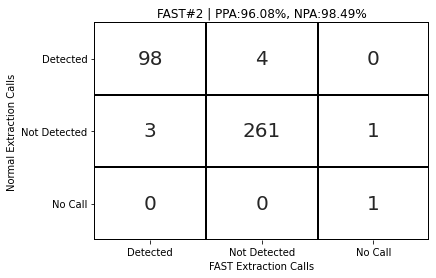

In [6]:
call_labels = ['detected', 'not_detected', 'no_call']

true_calls = list(combined.call_norm.values)
fast_calls = list(combined.call_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, labels=call_labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_yticklabels(['Detected', 'Not Detected', 'No Call'])
ax.set_xlabel('FAST Extraction Calls')
ax.set_ylabel('Normal Extraction Calls')

a,b,c,d,e,f,g,h,i = cf_matrix.ravel()

plt.title(f'FAST#2 | PPA:{(a*100/(a+b+c)):.2f}%, NPA:{(e*100/(d+e+f)):.2f}%')

plt.yticks(rotation=0)
plt.show()

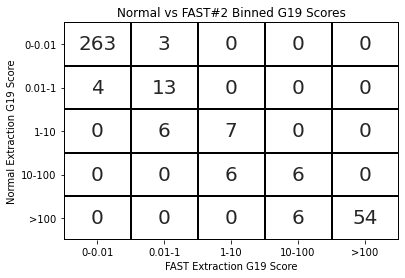

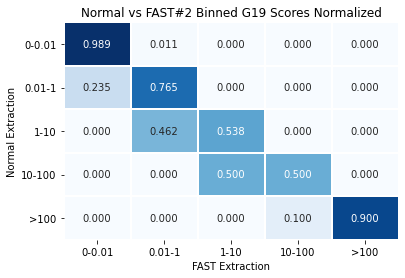

In [7]:
true_calls = list(combined.category_norm.values)
fast_calls = list(combined.category_fast.values)

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, labels=labels)
ax = sns.heatmap(cf_matrix, cmap=ListedColormap(['white']),
                 annot=True, annot_kws={"size": 20}, fmt='d',
                 cbar=False, linewidths=1, linecolor='black')

ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_xlabel('FAST Extraction G19 Score')
ax.set_ylabel('Normal Extraction G19 Score')

plt.title('Normal vs FAST#2 Binned G19 Scores')

plt.yticks(rotation=0)
plt.show()

cf_matrix = metrics.confusion_matrix(true_calls, fast_calls, normalize='true')
ax2 = sns.heatmap(cf_matrix, cmap='Blues', annot=True,
                  linewidths=1, fmt='.3f', cbar=False)
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)
ax2.set_xlabel('FAST Extraction')
ax2.set_ylabel('Normal Extraction')

plt.title('Normal vs FAST#2 Binned G19 Scores Normalized')

plt.yticks(rotation=0)
plt.show()

# Plate Comparison

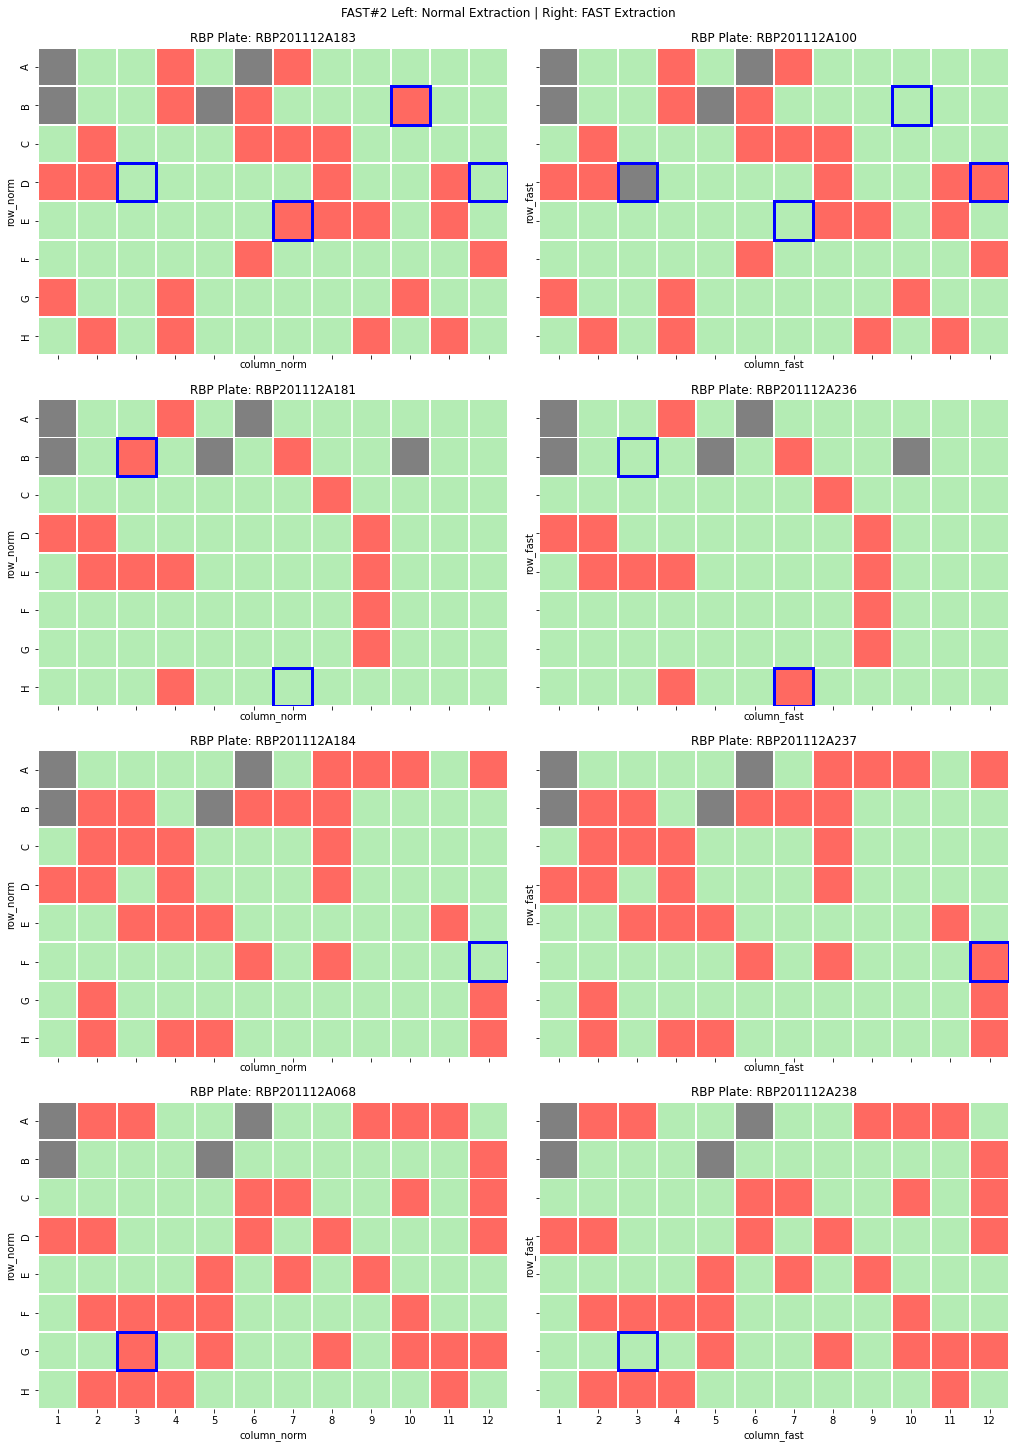

In [8]:
total_cols = 2
total_rows = 4

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, sharex=True, sharey=True,
                        figsize=(7*total_cols, 5*total_rows), constrained_layout=True, squeeze=False)

fig.suptitle(f'FAST#2 Left: Normal Extraction | Right: FAST Extraction')
fig.set_facecolor('white')
ax.tick_params(direction='out', length=6, color='black')

row_to_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3,
              'E': 4, 'F': 5, 'G': 6, 'H': 7}

for i, j, k in zip(combined.RBP_norm.unique(), combined.RBP_fast.unique(), range(4)):

    norm = combined[combined['RBP_norm'] == i]
    norm_pivot = norm.pivot(
        index='row_norm', columns='column_norm', values='total_detected_norm')
    mask_norm = norm_pivot.isnull()

    norm_fig = sns.heatmap(norm_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][0], mask=mask_norm, linewidths=1)
    norm_fig.set_facecolor('grey')

    axs[k][0].set_title(f'RBP Plate: {i}')

    fast = combined[combined['RBP_fast'] == j]
    fast_pivot = fast.pivot(
        index='row_fast', columns='column_fast', values='total_detected_fast')
    mask_fast = fast_pivot.isnull()

    fast_fig = sns.heatmap(fast_pivot, cbar=False, cmap=ListedColormap(
        ['#b4ecb4', '#ff6961']), ax=axs[k][1], mask=mask_fast, linewidths=1)
    fast_fig.set_facecolor('grey')
    axs[k][1].set_title(f'RBP Plate: {j}')

    drop_norm = norm[~((norm['total_detected_norm'].isna())
                       & (fast['total_detected_fast'].isna()))]
    drop_fast = fast[~((norm['total_detected_norm'].isna())
                       & (fast['total_detected_fast'].isna()))]

    for i in drop_norm[drop_norm['total_detected_norm'].values != drop_fast['total_detected_fast'].values].loc[:, ['row_norm', 'column_norm']].values:
        norm_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))
        fast_fig.add_patch(Rectangle(
            (i[1] - 1, row_to_num[i[0]]), 1, 1, fill=False, edgecolor='blue', lw=3))

# fig.savefig('fastconcordance2.png', dpi=300)

### Discordant Wells

In [9]:
drop_comb = combined[~((combined['total_detected_norm'].isna())
                       & (combined['total_detected_fast'].isna()))]

drop_comb[(drop_comb['total_detected_norm'] != drop_comb['total_detected_fast'])]\
    .loc[:, ['RBP_norm', 'RBP_fast', 'well', 'median_covid_ratio_norm', 'median_covid_ratio_fast']]

,RBP_norm,RBP_fast,well,median_covid_ratio_norm,median_covid_ratio_fast
127,RBP201112A183,RBP201112A100,E7,0.06926,0.00000
106,RBP201112A183,RBP201112A100,D12,0.00000,0.03546
114,RBP201112A183,RBP201112A100,B10,0.03013,0.00000
173,RBP201112A183,RBP201112A100,D3,0.00000,0.00000
11,RBP201112A181,RBP201112A236,H7,0.00000,0.01422
52,RBP201112A181,RBP201112A236,B3,0.07466,0.00000
194,RBP201112A184,RBP201112A237,F12,0.00000,0.13658
315,RBP201112A068,RBP201112A238,G3,0.05472,0.00680


### Normal Covid Score vs FAST Covid Score

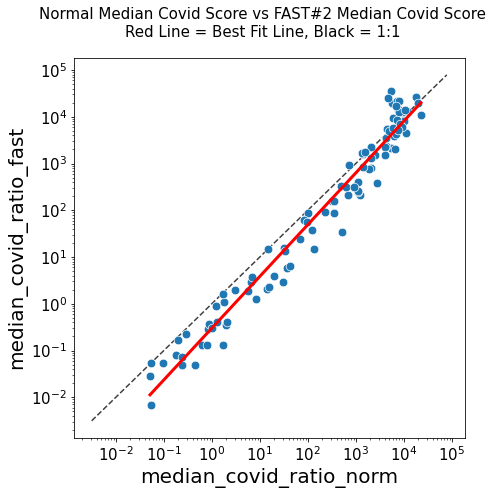

In [10]:
score_relation = combined.query("(total_detected_norm == 1 | total_detected_fast == 1) & \
                                 (median_covid_ratio_norm > 0 & median_covid_ratio_fast > 0)")

fig, ax = plt.subplots(figsize=(7, 7))
fig.set_facecolor('white')
ax.set(xscale='log', yscale='log')

sns.scatterplot(data=score_relation, x='median_covid_ratio_norm',
                y='median_covid_ratio_fast', s=75)

x = score_relation['median_covid_ratio_norm'].values
y = score_relation['median_covid_ratio_fast'].values

new_x, new_y = zip(*sorted(zip(x, y)))

logA = np.log(new_x)
logB = np.log(new_y)

m, c = np.polyfit(logA, logB, 1)
y_fit = np.exp(m*logA + c)
plt.plot(new_x, y_fit, 'r', linewidth=3)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
fig.suptitle('Normal Median Covid Score vs FAST#2 Median Covid Score\n\
Red Line = Best Fit Line, Black = 1:1', fontsize=15)

plt.show()

In [11]:
sort_mapping = {'RBP201112A183': 1,
                'RBP201112A181': 2,
                'RBP201112A184': 3,
                'RBP201112A068': 4}

## Look at Singlicate for Discordant Wells ##
singlicate = pd.read_pickle(
    "/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_read_counts.pickle")

singlicate_norm = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_norm.values)].dropna(how='all', axis=1)
singlicate_fast = singlicate[singlicate['run_sample_id'].isin(
    combined.run_sample_id_fast.values)].dropna(how='all', axis=1)

singlicate_norm['well'] = singlicate_norm['pos_tube_rack'].str.split(
    pat=':').str[1]
singlicate_norm['RBP'] = singlicate_norm['pos_tube_rack'].str.split(
    pat=':').str[0]
singlicate_norm['sort'] = singlicate_norm['RBP'].map(sort_mapping)

singlicate_fast['well'] = singlicate_fast['pos_tube_rack'].str.split(
    pat=':').str[1]
singlicate_fast['RBP'] = singlicate_fast['pos_tube_rack'].str.split(
    pat=':').str[0]

## Create Table of Discordant Sample ID for Normal and FAST ##
drop_comb = combined[~((combined['total_detected_norm'].isna()) & (combined['total_detected_fast'].isna()))]
discordant = drop_comb[(drop_comb['total_detected_norm'] != drop_comb['total_detected_fast'])].loc[:, [
    'run_sample_id_norm', 'run_sample_id_fast']]

## Find Discordant Samples for Normal and FAST ##
single_norm = singlicate_norm[singlicate_norm['run_sample_id'].isin(discordant.run_sample_id_norm.values)].sort_values(by=['sort', 'well', 'covid_ratio']).add_suffix('_norm').reset_index()
single_fast = singlicate_fast[singlicate_fast['run_sample_id'].isin(discordant.run_sample_id_fast.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast').reset_index()

## Concat Discordant Samples into one df ##
single_discord = pd.concat([single_norm, single_fast], axis=1).drop(columns='index')

single_discord.loc[:, ['well_norm', 'covid_ratio_norm', 'covid_ratio_fast', 'replicate_call_norm', 'replicate_call_fast', 'RBP_fast']]

,well_norm,covid_ratio_norm,covid_ratio_fast,replicate_call_norm,replicate_call_fast,RBP_fast
0,B10,0.02875,0.00000,detected,not_detected,RBP201112A100
1,B10,0.03013,0.00000,detected,not_detected,RBP201112A100
2,B10,0.03259,0.02220,detected,detected,RBP201112A100
3,D12,0.00000,0.00000,not_detected,not_detected,RBP201112A100
4,D12,0.00000,0.03546,not_detected,detected,RBP201112A100
5,D12,0.00002,0.05254,not_detected,detected,RBP201112A100
6,D3,0.00000,0.00000,not_detected,no_call,RBP201112A100
7,D3,0.00000,0.00000,not_detected,not_detected,RBP201112A100
8,D3,0.00000,0.00000,not_detected,no_call,RBP201112A100
9,E7,0.04017,0.00000,detected,not_detected,RBP201112A100


In [12]:
single_discord.loc[:,['well_norm',
                      'covid_count_norm', 'covid_count_fast',
                      'covid_ratio_norm', 'covid_ratio_fast',
                      'rnase_count_norm', 'rnase_count_fast',
                      'spikein_count_norm', 'spikein_count_fast',
                      'replicate_call_norm', 'replicate_call_fast']]

,well_norm,covid_count_norm,covid_count_fast,covid_ratio_norm,covid_ratio_fast,rnase_count_norm,rnase_count_fast,spikein_count_norm,spikein_count_fast,replicate_call_norm,replicate_call_fast
0,B10,1687.0,0.0,0.02875,0.00000,12781.0,2576.0,58679.0,5872.0,detected,not_detected
1,B10,1597.0,0.0,0.03013,0.00000,16663.0,4042.0,52997.0,12437.0,detected,not_detected
2,B10,715.0,370.0,0.03259,0.02220,6641.0,3508.0,21936.0,16666.0,detected,detected
3,D12,0.0,0.0,0.00000,0.00000,2827.0,895.0,144795.0,23514.0,not_detected,not_detected
4,D12,0.0,585.0,0.00000,0.03546,8779.0,1075.0,169921.0,16498.0,not_detected,detected
5,D12,1.0,603.0,0.00002,0.05254,2581.0,2112.0,50024.0,11476.0,not_detected,detected
6,D3,0.0,0.0,0.00000,0.00000,4836.0,721.0,57284.0,8.0,not_detected,no_call
7,D3,0.0,0.0,0.00000,0.00000,9648.0,1786.0,45521.0,1865.0,not_detected,not_detected
8,D3,0.0,0.0,0.00000,0.00000,10890.0,1037.0,42303.0,236.0,not_detected,no_call
9,E7,1709.0,0.0,0.04017,0.00000,3592.0,4672.0,42545.0,9447.0,detected,not_detected


### RNAse of No Call Wells

In [13]:
rnase_discord = combined[(combined['total_detected_norm'].isna()) | (combined['total_detected_fast'].isna())]

rnase_norm = singlicate_norm[singlicate_norm['run_sample_id'].isin(rnase_discord.run_sample_id_norm.values)].sort_values(by=['sort', 'well', 'covid_ratio']).add_suffix('_norm').reset_index()
rnase_fast = singlicate_fast[singlicate_fast['run_sample_id'].isin(rnase_discord.run_sample_id_fast.values)].sort_values(by=['RBP', 'well', 'covid_ratio']).add_suffix('_fast').reset_index()

## Concat Discordant Samples into one df ##
rnase_discord = pd.concat([rnase_norm, rnase_fast], axis=1).drop(columns='index')

rnase_discord.loc[:, ['well_norm', 'rnase_count_norm', 'rnase_count_fast', 'RBP_fast']]


,well_norm,rnase_count_norm,rnase_count_fast,RBP_fast
0,D3,4836.0,721.0,RBP201112A100
1,D3,9648.0,1786.0,RBP201112A100
2,D3,10890.0,1037.0,RBP201112A100
3,B10,0.0,0.0,RBP201112A236
4,B10,1.0,0.0,RBP201112A236
5,B10,6.0,0.0,RBP201112A236


### Spikein Count of No Call Well (FAST RBP201112A100:D3)

In [14]:
singlicate[singlicate['pos_tube_rack'] == 'RBP201112A100:D3'].loc[:,['spikein_count', 'covid_ratio', 'replicate_call', 'replicate_flags', 'pos_tube_rack']]

,spikein_count,covid_ratio,replicate_call,replicate_flags,pos_tube_rack
43,8.0,0.0,no_call,low_covid_plus_spikein,RBP201112A100:D3
206,1865.0,0.0,not_detected,pass,RBP201112A100:D3
371,236.0,0.0,no_call,low_covid_plus_spikein,RBP201112A100:D3


### Days in 4C

In [15]:
df_norm['run_date'] = datetime(2020, 12, 14)
df_norm['time_in_4C'] = df_norm['run_date'] - df_norm['date']

df_norm.groupby('RBP').agg({'date':'max',
                            'run_date':'max',
                            'time_in_4C':'max'}).sort_values(by='date')

,date,run_date,time_in_4C
RBP,,,
RBP201112A068,2020-12-03,2020-12-14,11 days
RBP201112A181,2020-12-05,2020-12-14,9 days
RBP201112A183,2020-12-05,2020-12-14,9 days
RBP201112A184,2020-12-05,2020-12-14,9 days
